In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os
import sys
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import nibabel as nib
from torchvision.transforms.functional import pad, center_crop
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0

In [142]:
## made with help from AI

class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image_path"]
        mask_path = self.df.loc[idx, "mask_path"]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Konverter fra BGR (cv2) til RGB (albumentations)
        mask = cv2.imread(mask_path, 0)  # Læs maske som gråtone

        if self.transforms:
            augmented = self.transforms(image=img, 
                                        mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Normalisering sker i Albumentations (A.Normalize)
        # Vi skal bare tilføje kanal-dimensionen til masken
        mask = mask.float() / 255.0 # Sørg for at masken er [0, 1]
        mask = mask.unsqueeze(0)
        return image, mask

def diagnosis(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return 0
    return int(np.max(mask) != 0)

def get_loaders(
    image_dir: str,  # --- ÆNDRET: Direkte sti til billeder
    mask_dir: str,   # --- ÆNDRET: Direkte sti til masker
    batch_size: int,
    img_size: int,
    num_workers: int,
    test_size: float = 0.1,
    random_state: int = 42,
    stratify_col: str = "diagnosis"):
    
    # --- LOAD DATA (RETTET LOGIK) ---
    # Finder alle .png-billeder i billedmappen
    imgs = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    
    # Bygger stier til de tilsvarende masker
    masks = []
    for img_path in imgs:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        if os.path.exists(mask_path):
            masks.append(mask_path)
        else:
            print(f"Advarsel: Mangler maske for {img_path}")
            imgs.remove(img_path) # Sørg for at listen er ens

    df_final = pd.DataFrame({
        "image_path": imgs,
        "mask_path": masks,
    })
    # --- SLUT PÅ RETTET LOGIK ---

    if df_final.empty:
        raise ValueError(f"Ingen matchende billede/maske-par fundet i {image_dir} og {mask_dir}")

    df_final["diagnosis"] = df_final["mask_path"].apply(diagnosis)

    # --- Transforms ---
    transforms = A.Compose([
        A.Resize(width = img_size, height = img_size, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1.0), # Normaliserer 3 kanaler
        ToTensorV2() # Konverterer til (C, H, W) tensor
        ])

    # --- Split data ---
    train_df, test_df = train_test_split(
        df_final,
        test_size=test_size,
        random_state=random_state,
        stratify=df_final[stratify_col] if stratify_col in df_final.columns else None
    )

    # --- Create datasets ---
    train_ds = MRIDataset(train_df, transform=transforms)
    test_ds = MRIDataset(test_df, transform=transforms)

    print(f"Train set size: {len(train_ds)}")
    print(f"Test set size: {len(test_ds)}")

    # --- DataLoaders ---
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, test_loader

In [ ]:
def double_conv(in_channels, out_channels):
    """
    Two 3x3 convolutions with padding=1.
    This keeps the HxW dimensions the SAME.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
                
        self.conv_down1 = double_conv(in_channels, 16)
        self.conv_down2 = double_conv(16, 32)
        self.conv_down3 = double_conv(32, 64)
        self.conv_down4 = double_conv(64, 128)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(64 + 128, 64)
        self.conv_up2 = double_conv(32 + 64, 32)
        self.conv_up1 = double_conv(32 + 16, 16)
        
        self.last_conv = nn.Conv2d(16, num_classes, kernel_size=1)
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)     
        conv2 = self.conv_down2(x)  
        x = self.maxpool(conv2)     
        conv3 = self.conv_down3(x) 
        x = self.maxpool(conv3)     
        x = self.conv_down4(x)      
        x = self.upsample(x)        
    

        x = torch.cat([x, conv3], dim=1) 
        x = self.conv_up3(x) 
        x = self.upsample(x)   
        x = torch.cat([x, conv2], dim=1) 
        x = self.conv_up2(x) 
        x = self.upsample(x)      
        x = torch.cat([x, conv1], dim=1) 
        
        x = self.conv_up1(x)
        
        out = self.last_conv(x)
        
        return out

In [139]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.weight = weight
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        
        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        dice_loss = 1 - dice_score
        
        return (self.weight * dice_loss) + ((1 - self.weight) * bce_loss)


Using device: mps
Loading data from: /Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_2/02456_Deep_learning/Project/archive/images
Loading labels from: /Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_2/02456_Deep_learning/Project/archive/masks
Train set size: 2451
Test set size: 613

--- Starting Training ---
  Epoch 1 | Batch 1/613 | Batch Loss: 0.8841
  Epoch 1 | Batch 2/613 | Batch Loss: 0.8782
  Epoch 1 | Batch 3/613 | Batch Loss: 0.8745
  Epoch 1 | Batch 4/613 | Batch Loss: 0.8818
  Epoch 1 | Batch 5/613 | Batch Loss: 0.8550
  Epoch 1 | Batch 6/613 | Batch Loss: 0.8602
  Epoch 1 | Batch 7/613 | Batch Loss: 0.8495
  Epoch 1 | Batch 8/613 | Batch Loss: 0.8591
  Epoch 1 | Batch 9/613 | Batch Loss: 0.8716
  Epoch 1 | Batch 10/613 | Batch Loss: 0.8525
  Epoch 1 | Batch 11/613 | Batch Loss: 0.8472
  Epoch 1 | Batch 12/613 | Batch Loss: 0.8686
  Epoch 1 | Batch 13/613 | Batch Loss: 0.8405
  Epoch 1 | Batch 14/613 | Batch Loss: 0.8263
  Epoch 1 | Batch 15/613 | Batch Loss: 0.

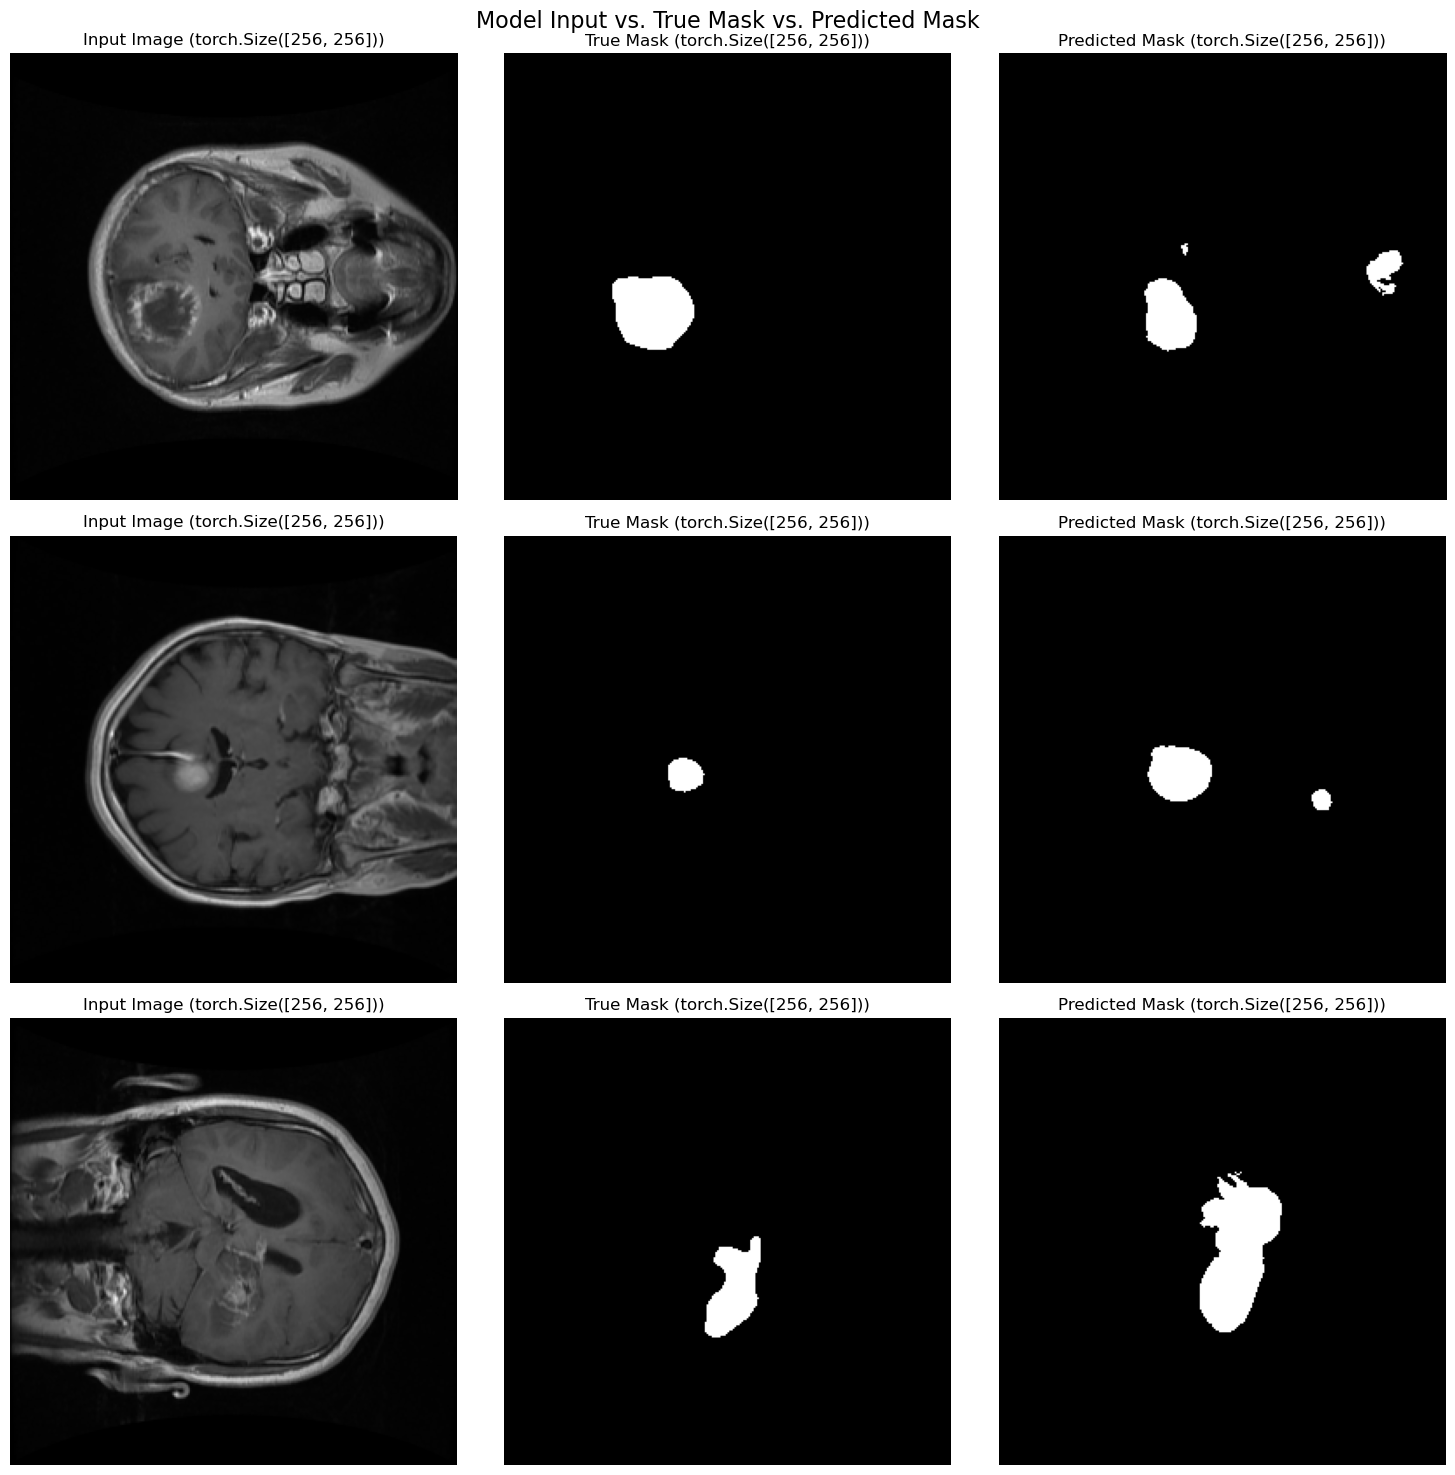

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5):
    print("\n--- Starting Training ---")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        num_batches = len(train_loader) 
        if num_batches == 0:
            print("Warning: Training data loader is empty.")
            continue
            
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

            print(f"  Epoch {epoch+1} | Batch {batch_idx+1}/{num_batches} | Batch Loss: {loss.item():.4f}")
        
        model.eval()
        val_loss = 0.0
        
        num_val_batches = len(val_loader)
        if num_val_batches == 0:
            print("Warning: Validation data loader is empty.")
            avg_train_loss = train_loss / num_batches
            print(f"Epoch {epoch+1}/{num_epochs} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss: N/A")
            continue

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
        avg_train_loss = train_loss / num_batches
        avg_val_loss = val_loss / num_val_batches
        
        print(f"\nEpoch {epoch+1}/{num_epochs} SUMMARY | Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}\n")
    
    print("--- Training Finished ---")


def visualize_results(model, loader, device, num_to_show=3):
    print(f"\n--- Visualizing {num_to_show} validation examples ---")
    model.eval()
    
    try:
        images, masks = next(iter(loader))
    except StopIteration:
        print("Data loader is empty, skipping visualization.")
        return

    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(num_to_show, 3, figsize=(15, 5 * num_to_show))
    fig.suptitle("Model Input vs. True Mask vs. Predicted Mask", fontsize=16)

    for i in range(num_to_show):
        if i >= len(images): 
            break
            
        img_display = images[i].permute(1, 2, 0).numpy()
        img_display = (img_display * 0.5) + 0.5 # Un-normalize [-1, 1] to [0, 1]
        img_display = np.clip(img_display, 0, 1)

        ax = axes[i, 0] if num_to_show > 1 else axes[0]
        ax.imshow(img_display)
        ax.set_title(f"Input Image ({images[i].shape[-2:]})")
        ax.axis('off')

        ax = axes[i, 1] if num_to_show > 1 else axes[1]
        ax.imshow(masks[i].squeeze(), cmap='gray')
        ax.set_title(f"True Mask ({masks[i].shape[-2:]})")
        ax.axis('off')

        ax = axes[i, 2] if num_to_show > 1 else axes[2]
        ax.imshow(preds[i].squeeze(), cmap='gray')
        ax.set_title(f"Predicted Mask ({preds[i].shape[-2:]})")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig("model_visualization.png")
    print("Visualization saved as 'model_visualization.png'")



if __name__ == "__main__":
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # config
    IMG_SIZE = 256
    BATCH_SIZE = 4
    NUM_EPOCHS = 1
    LEARNING_RATE = 1e-4
    NUM_WORKERS = 0
    
    try:
        # define path to data
        base_dir = Path.cwd() 
        DATA_ROOT = base_dir.parent / "archive" 
        image_folder = DATA_ROOT / "images"
        mask_folder = DATA_ROOT / "masks"
        
        print(f"Loading data from: {image_folder}")
        print(f"Loading labels from: {mask_folder}")
        
        # dataloader
        train_loader, val_loader = get_loaders(
            image_dir=image_folder,
            mask_dir=mask_folder,
            batch_size=BATCH_SIZE,
            img_size=IMG_SIZE,
            num_workers=NUM_WORKERS,
            test_size=0.2 
        )
        
        # model define
        model = SimpleUNet(in_channels=3, num_classes=1).to(device)
        
        # loss and optimizer
        criterion = DiceBCELoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        # train
        train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=NUM_EPOCHS)
        
        if len(val_loader) > 0:
            visualize_results(model, val_loader, device, num_to_show=3)

    except Exception as e:
        print(f"\n--- EN FEJL OPSTOD ---")
        print(f"Fejl: {e}")
        print("\n--- ALMINDELIGE LØSNINGER ---")
        print("1. Kør 'pip install opencv-python-headless albumentations pandas'")
        print(f"2. Tjek at din data-sti er korrekt. Scriptet leder i:")
        print(f"   Image folder: {image_folder}")
        print(f"   Mask folder:  {mask_folder}")

In [141]:
unet = SimpleUNet().to(device)
output = unet(torch.randn(1,1,512,512).to(device))
print(output.shape)

torch.Size([1, 1, 512, 512])
